# Hyperfine structure of alkali atoms in a magnetic field

In [3]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import pandas as pd
%matplotlib notebook

We plot the eigenspectrum of a Hamiltonian which considers magnetic dipole and electric quadrupole internal hyperfine structure, as well as coupling to an external magnetic field,
$$H = A_{hfs} \vec{I}\cdot\vec{J} + B_{hfs} \frac{3(\vec{I}\cdot\vec{J})^2 + 3\vec{I}\cdot\vec{J}/2 - \vec{I}^2 \vec{J}^2 }{2I(2I-1)J(2J-1)}+ (g_I I_z + g_J J_z)\mu_B B_z/h,$$
for arbitrary nuclear/electronic angular momentum $I,J$. Recall for $J=1/2$ and $B_{hfs} = 0$ (no electric quadrupole), the Breit-Rabi formula offers an analytical solution.

In [10]:
%matplotlib notebook
hbar = 1.05457182*10**(-34) # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton
a0 = 5.2917720859e-11    # Bohr radius
mu_0 = muB/(2*np.pi*hbar) * 1e-6 * 1e-4
def spectrum_at_Bfield(Bz,
                      manifold = '40K D2', 
                      show_qtm_nums = True):
    
    if manifold == '40K D2':
    #values taken from Tiecke
        I = 4 
        J = 3/2 
        ah = -7.585
        bh = -3.445
        g_I = 0.00017649 
        g_J = 1.334102228
        plt.title(r'40K D2, $I=${I}, $J=${J}'.format(I=I, J=J), fontsize = 20)
    
    if manifold == '40K GS':
        ah = -285.7308
        I = 4 
        J = 1/2 
        bh = 0
        g_I = 0.00017649 
        g_J = 2.00229421
        plt.title(r'40K GS, $I=${I}, $J=${J}'.format(I=I, J=J), fontsize = 20)
        
    H_hfs = 0
    I_dot_J, I_sq, J_sq = 0, 0, 0
    for J_i in [spin_Jx, spin_Jy, spin_Jz]:
        I_dot_J += tensor(J_i(I), J_i(J))
        I_sq += tensor(J_i(I)**2, qeye(int(2*J + 1)))
        J_sq += tensor(qeye(int(2*I + 1)), J_i(J)**2)
    H_hfs = ah * I_dot_J
    if bh != 0:
        H_hfs += bh / (2 * I * (2*I - 1) * J * (2*J-1)) * (3 * I_dot_J / 2 + 3* (I_dot_J)**2 - I_sq * J_sq)
    #external field term
    I_z, J_z = tensor(spin_Jz(I), qeye(int(2*J + 1))), tensor(qeye(int(2*I + 1)),spin_Jz(J))
    H = H_hfs + (g_I * I_z +  g_J * J_z) * mu_0 * Bz
    eigvals, eigvecs = H.eigenstates()
    data = {'B_field (G)': np.ones_like(eigvals) * Bz, 'eigenenergy (MHz)': eigvals}
    if show_qtm_nums:
        def expectation_and_stdev(operator):
            expectation = np.array([(eigvec.dag() * operator * eigvec)[0] for eigvec in eigvecs])
            stdev = np.ones_like(expectation)
            for idx in range(len(expectation)):
                stdev[idx] = np.sqrt((eigvecs[idx].dag() * (operator - expectation[idx])**2 * eigvecs[idx])[0])
            expectation, stdev = np.real(expectation), np.real(stdev)
            return expectation.flatten(), stdev.flatten()
            
        #calculate expectations and standard deviations of F^2, Fz
        mF_expectation, _ = expectation_and_stdev(I_z + J_z)
        F_sq = 0
        for J_i in [spin_Jx, spin_Jy, spin_Jz]:
            F_sq += (tensor(J_i(I), qeye(int(2*J + 1))) + tensor(qeye(int(2*I + 1)), J_i(J))) ** 2
        F_sq_expectation, F_sq_stdev = expectation_and_stdev(F_sq)
            
        #calculate expectations and standard deviations of Jz, Iz
        mJ_expectation, mJ_stdev = expectation_and_stdev(J_z)
        mI_expectation, mI_stdev = expectation_and_stdev(I_z)
        data.update({'mF_expectation':mF_expectation,
#                'mF_stdev': mF_stdev,
               'F^2_expectation': F_sq_expectation,
                'F': .5 * (np.sqrt(4 * F_sq_expectation + 1) - 1), #invert F^2 ~ F(F+1)
               'F^2_stdev': F_sq_stdev,
               'mI_expectation': mI_expectation,
               'mI_stdev': mI_stdev,
               'mJ_expectation': mJ_expectation,
               'mJ_stdev': mJ_stdev})
    spectrum_df = pd.DataFrame(data)
    spectrum_df.sort_values(by='eigenenergy (MHz)', inplace=True)
    return spectrum_df
        
def plot_E_vs_B(B_min = 0, B_max = 1000, n_pts = 100, manifold = '40K D2'):
    plt.close()
    plt.style.use('seaborn')
    plt.figure(figsize = (8,6))
    for Bz in np.linspace(B_min,B_max,n_pts):
        eigvals = spectrum_at_Bfield(Bz, manifold = manifold)['eigenenergy (MHz)']
        plt.plot(np.ones_like(eigvals)*Bz, eigvals, 'ko', markersize = '1')
        plt.plot(Bz, np.mean(eigvals), 'ro', markersize = '1')
    plt.xlabel(r'$B$ (Gauss)', fontsize = 20)
    plt.ylabel(r'$E$ (MHz)', fontsize = 20)
    plt.tight_layout()
    plt.show()
    
plot_E_vs_B(manifold = '40K D2', B_max=200)

/var/folders/v2/qlb19m_922j0wts1jqdyjw100000gn/T/ipykernel_86515/2313431891.py:80: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<IPython.core.display.Javascript object>

## Good quantum numbers
Below we show $\langle F_z\rangle, \langle F^2\rangle, \langle I_z\rangle, \langle J_z\rangle$ and their standard deviations, where the standard deviation squared is $\sigma^2_\Omega = {\langle (\Omega - \langle \Omega \rangle)^2\rangle}$. Small standard deviation indicates an approximately good quantum number.

In [11]:
spectrum_at_Bfield(101, manifold = '40K GS')

<IPython.core.display.Javascript object>

,B_field (G),eigenenergy (MHz),mF_expectation,F^2_expectation,F,F^2_stdev,mI_expectation,mI_stdev,mJ_expectation,mJ_stdev
0,101.0,-713.085925,-4.5,24.750000,4.500000,0.000000,-4.000000,0.000000,-0.500000,0.000000
1,101.0,-686.849172,-3.5,24.718928,4.496892,0.527907,-3.076929,0.266478,-0.423071,0.266478
2,101.0,-659.673189,-2.5,24.691329,4.494129,0.724293,-2.158929,0.365610,-0.341071,0.365610
3,101.0,-631.449138,-1.5,24.668179,4.491811,0.854221,-1.246878,0.431195,-0.253122,0.431195
4,101.0,-602.045378,-0.5,24.650790,4.490069,0.939708,-0.341904,0.474348,-0.158096,0.474348
5,101.0,-571.300161,0.5,24.640959,4.489084,0.984622,0.554516,0.497019,-0.054516,0.497019
6,101.0,-539.011009,1.5,24.641219,4.489110,0.983462,1.440386,0.496433,0.059614,0.496433
7,101.0,-504.918721,2.5,24.655245,4.490516,0.918593,2.312937,0.463689,0.187063,0.463689
8,101.0,-468.682264,3.5,24.688582,4.493854,0.740938,3.168164,0.374012,0.331836,0.374012
9,101.0,-429.837275,4.5,24.750000,4.500000,0.000000,4.000000,0.000000,0.500000,0.000000


In [13]:
print(-713.085925--686.849172)

-26.23675300000002


# frequency differences between optical transitions within 40K D2 line
We examine $\sigma_+$, $\Delta m_F = 1$
$$|F=9/2, m_F=9/2\rangle \rightarrow |F'=11/2, m_F'=11/2\rangle$$ 
vs $\sigma_-$, $\Delta m_F = -1$
$$|F=9/2, m_F=-9/2\rangle \rightarrow |F'=11/2, m_F'=-11/2\rangle$$
.

<IPython.core.display.Javascript object>


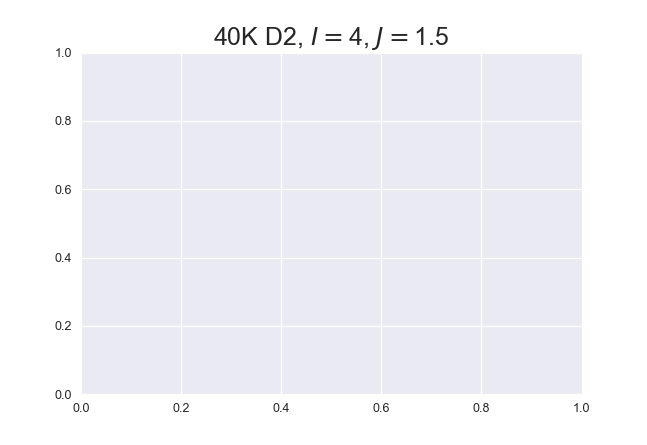

detuning (MHz) from 40K D2 line: |9/2,-9/2> to |11/2, -11/2> 
 441.08982609200007
detuning (MHz) from 40K D2 line: |9/2,9/2> to |11/2, 11/2> 
 609.0908739079999
difference (MHz), positive is blue:  168.00104781599987


In [32]:
b_field = 60
df_gs = spectrum_at_Bfield(b_field, manifold = '40K GS')
df_D2 = spectrum_at_Bfield(b_field, manifold = '40K D2')

E_92m92 = float(df_gs[df_gs['mF_expectation'] == -4.5]['eigenenergy (MHz)'])
E_9292 = float(df_gs[df_gs['mF_expectation'] == 4.5]['eigenenergy (MHz)'])

E_112m112 = float(df_D2[abs(df_D2['mF_expectation'] - -5.5) < 0.01]['eigenenergy (MHz)'])
E_112112 = float(df_D2[abs(df_D2['mF_expectation'] - 5.5) < 0.01]['eigenenergy (MHz)'])

detuningD2_sigma_minus = E_112m112 - E_92m92 # positive is blue
detuningD2_sigma_plus = E_112112 - E_9292
print('detuning (MHz) from 40K D2 line: |9/2,-9/2> to |11/2, -11/2> \n', E_112m112 - E_92m92)
print('detuning (MHz) from 40K D2 line: |9/2,9/2> to |11/2, 11/2> \n', E_112112 - E_9292)
print('difference (MHz), positive is blue: ', detuningD2_sigma_plus - detuningD2_sigma_minus)